In [638]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import glob

In [639]:
dfs=[]
for file in glob.glob("data/*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

In [640]:
selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'link',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	

df = df[selected_columns]
# replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = df['created_date'].astype(str)



df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 6 to 24
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype                     
---  ------             --------------  -----                     
 0   file_name          229 non-null    object                    
 1   uuid               229 non-null    object                    
 2   title              229 non-null    object                    
 3   content            229 non-null    object                    
 4   post_flair_text    229 non-null    object                    
 5   author             229 non-null    object                    
 6   author_flair_text  229 non-null    object                    
 7   created            229 non-null    datetime64[ns, US/Eastern]
 8   comments           229 non-null    int64                     
 9   score_up           229 non-null    int64                     
 10  preview            229 non-null    object                    
 11  link               229 no

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_5338/44779822.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)


In [641]:
df.created_date.value_counts().sort_index()

created_date
2024-07-21     62
2024-07-22    167
Name: count, dtype: int64

In [602]:
import spacy
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words)

# remove additional stopwords, such as Trump
# stopwords.append('trump')

import contractions
import emoji
import re
from tqdm import tqdm
tqdm.pandas()


def clean_it_all_up (text):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords
            and token.pos_ in {'NOUN', 'PROPN'} 
            and token.ent_type_ not in {'GPE', 'LOC'}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   

In [622]:
def ngram_generator(num, date):
    cleaned_tokens = ' '.join(df[df['created_date'] == date]['title'].progress_apply(clean_it_all_up).tolist())
    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1]
    return ngram


In [623]:
ngram_generator(2, '2024-07-21').head(10)

100%|██████████| 62/62 [00:00<00:00, 169.95it/s]


(kamala, harris)       6
(joe, biden)           5
(crooked, joe)         4
(harris, president)    3
(president, kamala)    2
(trump, puppet)        2
(harris, nominee)      2
(race, today)          2
(biden, race)          2
(tomorrow, crooked)    2
Name: count, dtype: int64

In [624]:
from wordcloud import WordCloud

def ngram_cloud(num, date, top_n=None):
    ngram = ngram_generator(num, date).head(top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

100%|██████████| 62/62 [00:00<00:00, 190.13it/s]


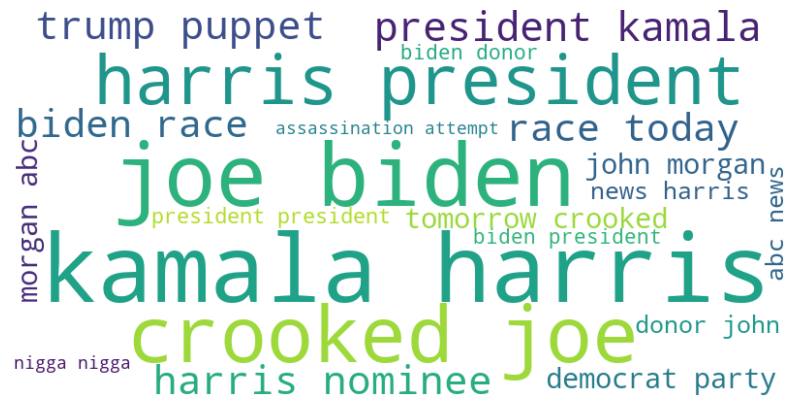

In [625]:
ngram_cloud(2, "2024-07-21")

In [626]:
# A summary table of authors based on a given date
def frequent_accounts(date):
    top_authors = df[df['created_date'] == date]['author'].value_counts().reset_index()
    top_authors = top_authors[top_authors['count']>1]
    comments_total = df.groupby('author').comments.sum()
    upvotes_total = df.groupby('author').score_up.sum()
    top_authors =  top_authors.merge(comments_total, on='author').merge(upvotes_total, on='author')
    top_authors = top_authors.rename(columns={'author': 'top_authors',
                                      'count': 'top_articles',
                                      'comments': 'accumulated_comments',
                                      'score_up': 'accumulated_upvotes'
                                      })
    top_authors = top_authors.sort_values('top_articles', ascending=False)
    return  top_authors

In [627]:
date = "2024-07-21"

top_authors = frequent_accounts(date)
top_authors.head(10)

,top_authors,top_articles,accumulated_comments,accumulated_upvotes
0,I-am-Orlando,6,408,7705
1,trees65,4,956,7048
2,Tcrussell,3,219,3685
3,RuprechtThaMonkeyBoy,3,323,5167
4,Trump_Is_My_Daddy,3,128,3243
5,LadyFannyofOmaha,3,664,6205
6,Meanderthal,2,22,952
7,Looniz74,2,194,2078
8,HumbleMemeFarmer,2,42,1469
9,DCSucks,2,13,846


In [628]:
df.domain.value_counts(normalize=True, dropna=False).head(10)

domain
twitter.com                 0.351598
media.scored.co             0.310502
media.patriots.win          0.191781
                            0.050228
rumble.com                  0.009132
thefederalist.com           0.009132
www.thegatewaypundit.com    0.009132
files.catbox.moe            0.009132
archive.ph                  0.004566
mises.org                   0.004566
Name: proportion, dtype: float64

In [631]:
# Popular Twitter accounts on The Ronald
date='2024-07-22'

df[(df.link.str.contains('twitter.com') )& (df.created_date== date)]['link'].str.split('/').str[3].value_counts(normalize=False, dropna=False)

link
catturd2           3
EndWokeness        3
elonmusk           2
LauraLoomer        2
PatriotPraetori    2
sallymayweather    1
usminitru          1
misha_saul         1
beinlibertarian    1
MikeCristo8        1
LibertyLockPod     1
TheChiefNerd       1
TomFitton          1
AGHamilton29       1
kylenabecker       1
TulsiGabbard       1
jakeshieldsajj     1
ofcrdeonjoseph     1
ChiefTrumpster     1
electionlegal      1
therubberduck79    1
RNCResearch        1
papitrumpo         1
RickyDoggin        1
libbyemmons        1
OwenShroyer1776    1
SantiagoAuFund     1
stevelovesammo     1
lamps_apple        1
shaneyyricch       1
RealJamesWoods     1
mtracey            1
pnjaban            1
ClownWorld_        1
TheBabylonBee      1
i                  1
disclosetv         1
rncresearch        1
PapiTrumpo         1
endwokeness        1
alibradleytv       1
lansing            1
VivekGRamaswamy    1
AuronMacintyre     1
UltraDane          1
mikelachance33     1
josephpino_        1
BillAckm